In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

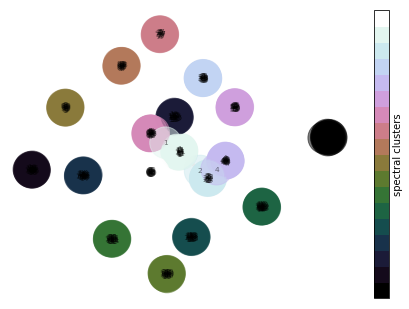

In [8]:
import numpy as np
from numpy import genfromtxt
import itertools as it

import generate_alphas as ga
import extreme_data as extr
import damex_algo as dmx
import clef_algo as clf

from sklearn.cluster import KMeans

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mlc


def reconstruct_alphas(alphas, feats, d_0):
    alphas_0 = [[feats[j] for j in alpha] for alpha in alphas]
    alphas_1 = []
    for alpha in alphas_0:
        alpha_1 = []
        for j in alpha:
            if j > d_0-1:
                alpha_1.append(j - d_0)
            else:
                alpha_1.append(j)
        alphas_1.append(alpha_1)

    return alphas_1

# Adjacency Matrix
gamma_z = np.load('results/gamma_z_dmx.npy')
n_extr, K_tot = gamma_z.shape
gamma_z = gamma_z[np.max(gamma_z, axis=1) > 1./K_tot + 1e-8]
n_extr, K = np.shape(gamma_z)
W = np.zeros((n_extr, n_extr))
for (i, j) in it.combinations(range(n_extr), 2):
    W[i, j] = np.sum(gamma_z[i] * gamma_z[j])
    W[j, i] = W[i, j]

# Spectral clustering
K_spec = K
L = np.diag(np.sum(W, axis=1)) - W
eigval, eigvect = np.linalg.eigh(L)
kmeans = KMeans(n_clusters=K_spec).fit(eigvect[:, :K_spec])
labels = kmeans.labels_
ind_extr = np.load('results/ind_extr.npy')
flights_ind = np.nonzero(ind_extr)[0]

# Final clusters
alphas = np.load('results/alphas.npy')
x_extr = np.load('results/extr_data.npy')
# y_extr = np.load('results/extr_lab.npy')
# K_lab = len(set(y_extr))
K_lab = len(set(labels))
d = x_extr.shape[1]
feats = [j for alpha in alphas for j in alpha]
flights_parameters_clusters = reconstruct_alphas(alphas, feats, d)

# Networkx visualisation 0
G = nx.from_numpy_matrix(W)
W_min = np.mean(W)
W_thresh = W*(W > W_min)
G_edges = []
weights_edges = []
for edge in G.edges():
    if W_thresh[edge] > W_min:
        G_edges.append(edge)
        weights_edges.append(W_thresh[edge])
G_visu = nx.from_numpy_matrix(W_thresh)
labels_dict = {i: str(labels[i])
               for i in range(n_extr)}

cmap = plt.get_cmap('cubehelix', K_lab)
pos = nx.spring_layout(G_visu, k=0.05)
nx.draw(G_visu,
        pos=pos,
        edgelist=G_edges,
        node_size=1e3,
        node_color=(K_lab - np.array(labels))/float(K_lab),
        alpha=0.5,
        cmap=cmap,
        edge_color=np.array(weights_edges),
        edge_cmap=plt.get_cmap(name='Reds'),
        font_size=7.5,
        labels=labels_dict
       )
sm = plt.cm.ScalarMappable(cmap=cmap)
sm._A = []
plt.colorbar(sm, ticks=[-0.5, K_spec+0.5], label='spectral clusters')
plt.show()

In [ ]:
# # Networkx visualisation with agglomerated points
# W_clusters = np.zeros((K_spec, K_spec))
# for k_0 in range(K_spec-1):
#     for k_1 in range(k_0+1, K_spec):
#         inds_k_0 = np.nonzero(labels == k_0)[0]
#         inds_k_1 = np.nonzero(labels == k_1)[0]
#         W_clusters[k_0, k_1] = np.sum(W[inds_k_0, :][:, inds_k_1])
#         W_clusters[k_1, k_0] = W_clusters[k_0, k_1]
# G_clusters = nx.from_numpy_matrix(W_clusters)
# node_color = []
# for node in G_clusters.nodes():
#     inds = np.nonzero(labels == node)[0]
#     node_color.append(np.sum(W[inds, :][:, inds])/np.sum(inds))
# G_clust_edges = []
# w_edges = []
# for edge in G_clusters.edges():
#     if W_clusters[edge] > 0.:
#         G_clust_edges.append(edge)
#         w_edges.append(W_clusters[edge])
# node_size = [np.sum(labels == k) for k in range(K_spec)]
# cmap = plt.get_cmap(name='Blues')
# labels_dict = {k: str(node_size[k]) for k in range(K_spec)}

# pos = nx.spring_layout(G_clusters, k=.2)
# nx.draw(G_clusters,
#         pos=pos,
#         node_size=5e2*np.array(node_size),
#         node_color=node_color,
#         alpha=0.75,
#         cmap=cmap,
#         edge_color=np.array(w_edges),
#         width=5,
#         # width=np.array(w_edges),
#         edge_cmap=plt.get_cmap(name='Reds'),
#         font_size=15,
#         labels=labels_dict)
# sm = plt.cm.ScalarMappable(cmap=cmap)
# sm._A = []
# plt.colorbar(sm, ticks=[-0.5, 1.5], label='intern connectivity')
# plt.show()